In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, countDistinct

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import min, max

import matplotlib.pyplot as plt
import pandas as pd

from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType

In [8]:
spark = SparkSession.builder \
    .appName("EDA on Mips Overall Performance data") \
    .getOrCreate()


In [40]:
df = spark.read.parquet("sample-data/doctorright-datalake/hive_metastore.mips_data.overall_performance.parquet")
df.printSchema()

root
 |-- NPI: integer (nullable = true)
 |-- Org_PAC_ID: long (nullable = true)
 |-- Provider_Last_Name: string (nullable = true)
 |-- Provider_First_Name: string (nullable = true)
 |-- source: string (nullable = true)
 |-- Facility_based_scoring_Certification_number: string (nullable = true)
 |-- Facility_Name: string (nullable = true)
 |-- Quality_category_score: double (nullable = true)
 |-- PI_category_score: double (nullable = true)
 |-- IA_category_score: integer (nullable = true)
 |-- Cost_category_score: double (nullable = true)
 |-- final_MIPS_score_without_CPB: double (nullable = true)
 |-- final_MIPS_score: double (nullable = true)



In [10]:
df.describe().show()

24/09/23 17:03:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+-------------------+------------------+-------------------+-------------+-------------------------------------------+-------------+----------------------+------------------+-----------------+-------------------+----------------------------+-----------------+
|summary|                 NPI|         Org_PAC_ID|Provider_Last_Name|Provider_First_Name|       source|Facility_based_scoring_Certification_number|Facility_Name|Quality_category_score| PI_category_score|IA_category_score|Cost_category_score|final_MIPS_score_without_CPB| final_MIPS_score|
+-------+--------------------+-------------------+------------------+-------------------+-------------+-------------------------------------------+-------------+----------------------+------------------+-----------------+-------------------+----------------------------+-----------------+
|  count|              624209|             622716|            624209|             624209|       624209|                              

In [11]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----------+------------------+-------------------+------+-------------------------------------------+-------------+----------------------+-----------------+-----------------+-------------------+----------------------------+----------------+
|NPI|Org_PAC_ID|Provider_Last_Name|Provider_First_Name|source|Facility_based_scoring_Certification_number|Facility_Name|Quality_category_score|PI_category_score|IA_category_score|Cost_category_score|final_MIPS_score_without_CPB|final_MIPS_score|
+---+----------+------------------+-------------------+------+-------------------------------------------+-------------+----------------------+-----------------+-----------------+-------------------+----------------------------+----------------+
|  0|      1493|                 3|                 22|     0|                                     624209|       624209|                 81763|           205798|            45237|             354199|                       31115|               0|
+---+----------+

In [12]:
df.dtypes

[('NPI', 'int'),
 ('Org_PAC_ID', 'bigint'),
 ('Provider_Last_Name', 'string'),
 ('Provider_First_Name', 'string'),
 ('source', 'string'),
 ('Facility_based_scoring_Certification_number', 'string'),
 ('Facility_Name', 'string'),
 ('Quality_category_score', 'double'),
 ('PI_category_score', 'double'),
 ('IA_category_score', 'int'),
 ('Cost_category_score', 'double'),
 ('final_MIPS_score_without_CPB', 'double'),
 ('final_MIPS_score', 'double')]

# Data Distribution Analysis

In [49]:
numeric_columns = [col for col, type in df.dtypes if type in ["int", "bigint", "float", "double"]]
numeric_columns

['NPI',
 'Org_PAC_ID',
 'Quality_category_score',
 'PI_category_score',
 'IA_category_score',
 'Cost_category_score',
 'final_MIPS_score_without_CPB',
 'final_MIPS_score']

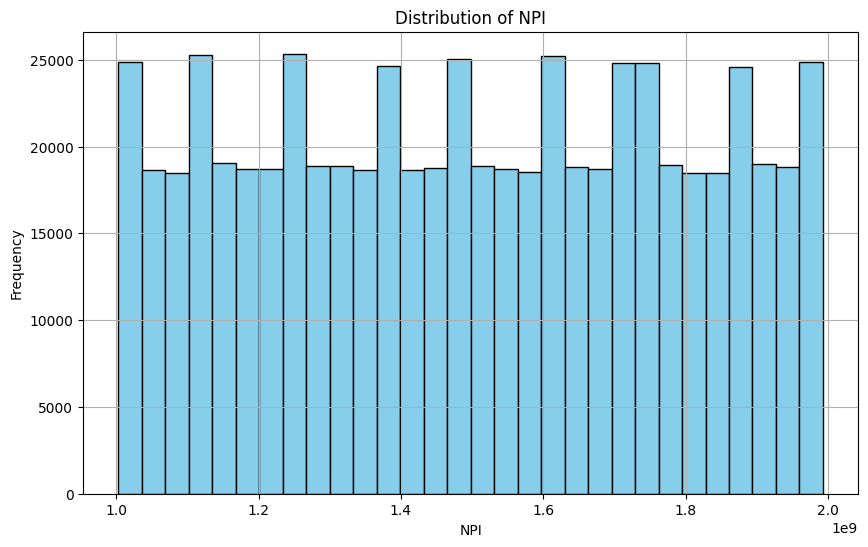

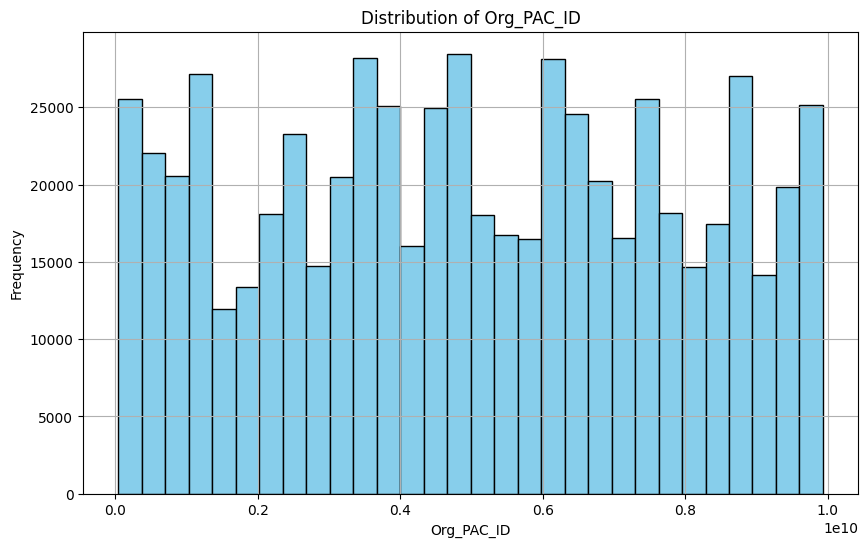

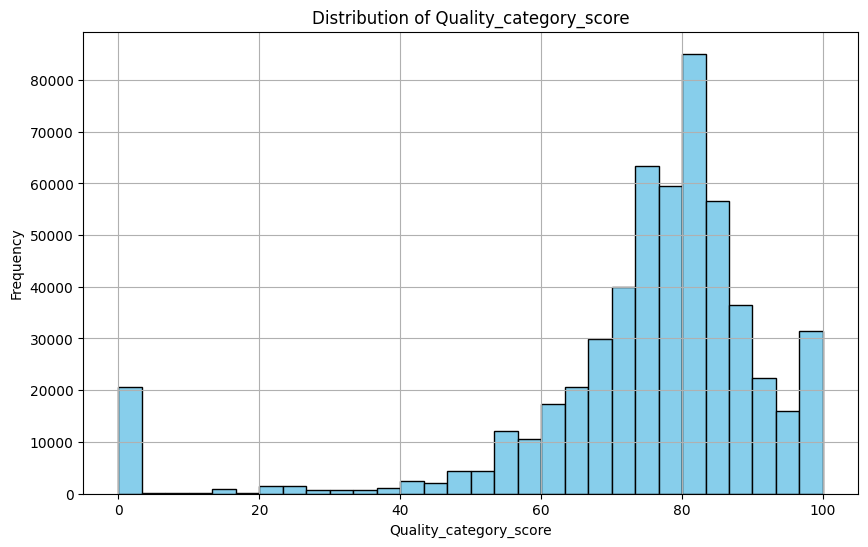

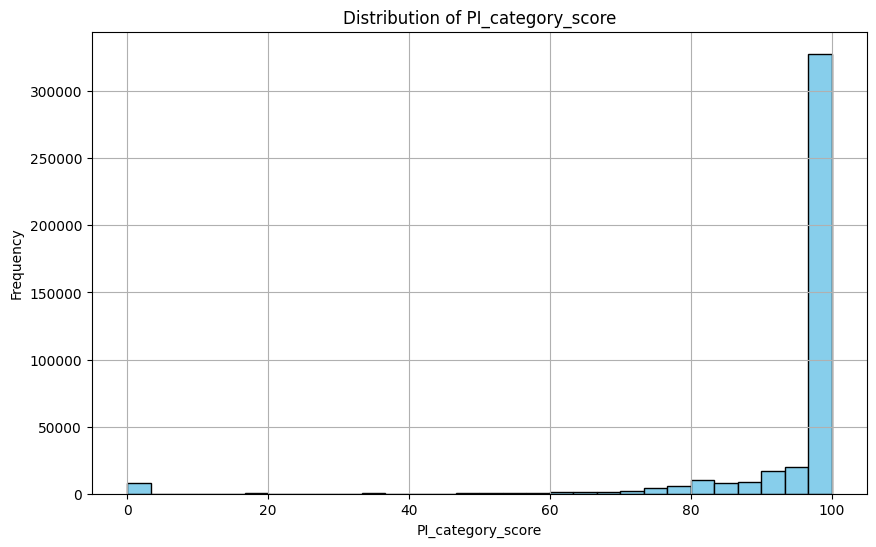

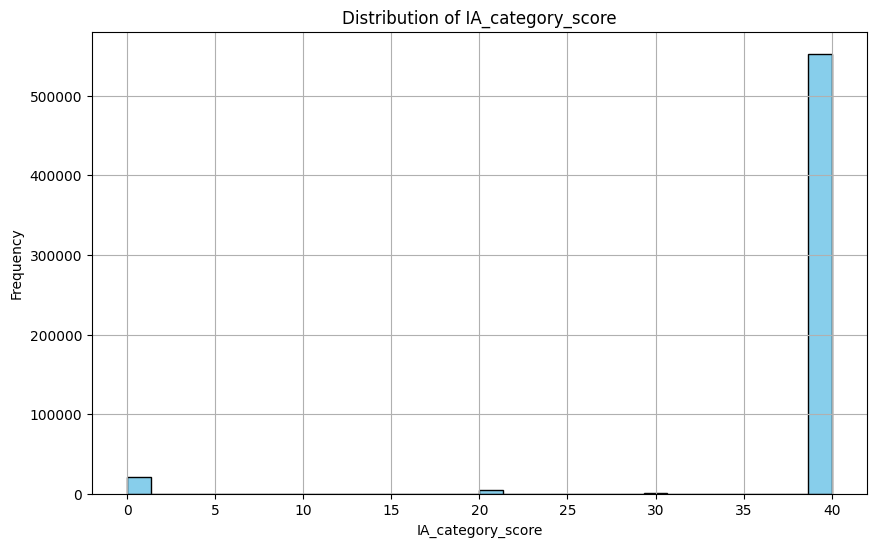

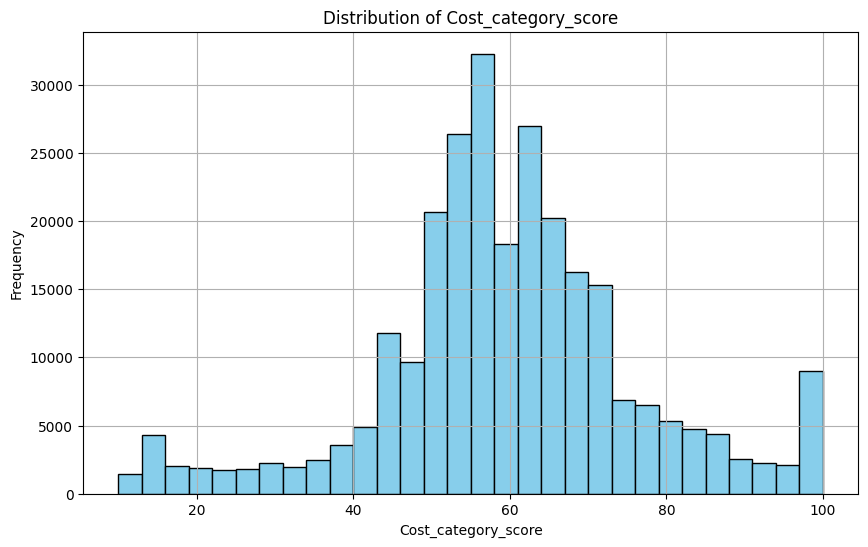

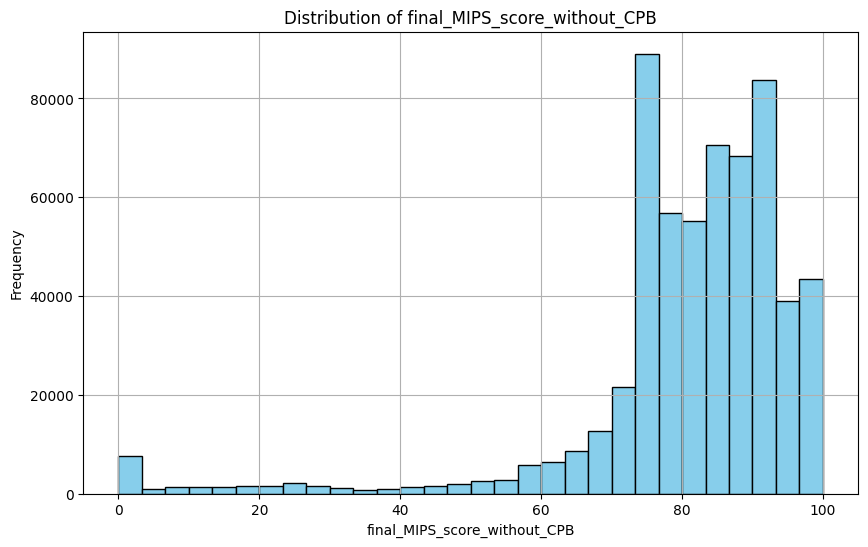

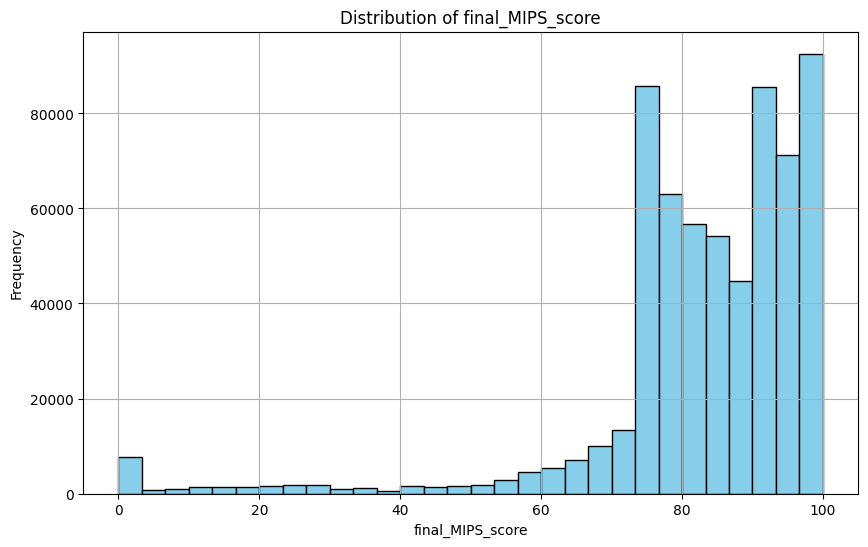

In [50]:

pandas_df = df.select(numeric_columns).toPandas()

for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.hist(pandas_df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Outlier Analysis

/var/folders/sq/1fd09v5n5zx39ctw_mddlq140000gn/T/ipykernel_12882/1270073998.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pandas_df['Quality_category_score'].dropna(),


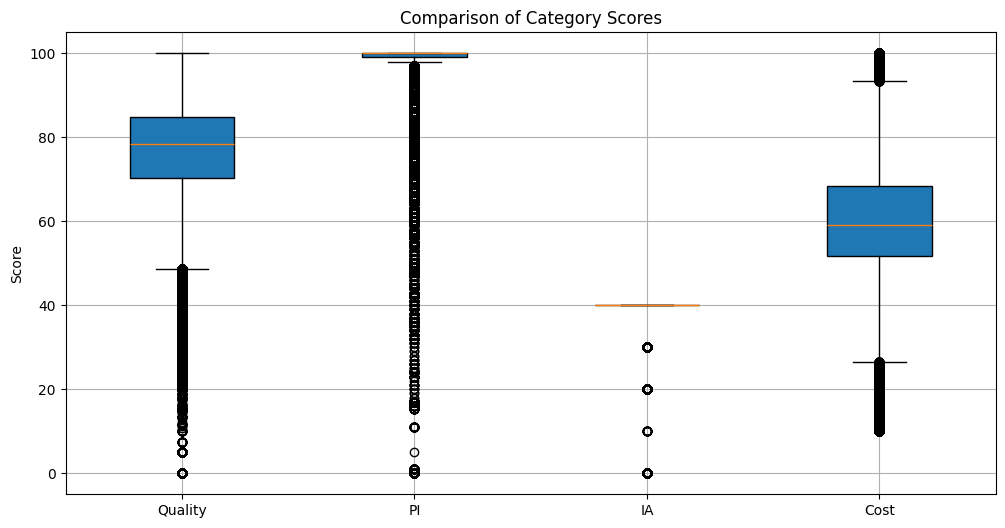

In [35]:
plt.figure(figsize=(12, 6))
plt.boxplot([pandas_df['Quality_category_score'].dropna(), 
             pandas_df['PI_category_score'].dropna(), 
             pandas_df['IA_category_score'].dropna(), 
             pandas_df['Cost_category_score'].dropna()], 
            labels=['Quality', 'PI', 'IA', 'Cost'], patch_artist=True)

plt.title('Comparison of Category Scores')
plt.ylabel('Score')
plt.grid(True)
plt.show()


In [22]:


# Convert necessary columns to double for outlier analysis
columns_to_analyze = ['Quality_category_score', 'PI_category_score', 'IA_category_score', 'Cost_category_score', 
                      'final_MIPS_score_without_CPB', 'final_MIPS_score']

# Convert columns to DoubleType if not already
for col_name in columns_to_analyze:
    df = df.withColumn(col_name, df[col_name].cast(DoubleType()))

# Z-Score calculation function
def z_score(df, col_name):
    mean_value = df.select(F.mean(col_name)).collect()[0][0]
    stddev_value = df.select(F.stddev(col_name)).collect()[0][0]
    
    df = df.withColumn(f'{col_name}_zscore', (F.col(col_name) - mean_value) / stddev_value)
    return df

# IQR calculation function
def iqr_outliers(df, col_name):
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df = df.withColumn(f'{col_name}_outliers', F.when((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound), 1).otherwise(0))
    return df

# Perform outlier detection for each column
for col_name in columns_to_analyze:
    df = z_score(df, col_name)
    df = iqr_outliers(df, col_name)

# Show the dataframe with Z-Scores and outlier flags
df.select(columns_to_analyze + [f'{col}_zscore' for col in columns_to_analyze] + [f'{col}_outliers' for col in columns_to_analyze]).show(10)

# Count number of outliers for each column
for col_name in columns_to_analyze:
    outlier_count = df.filter(F.col(f'{col_name}_outliers') == 1).count()
    print(f'Number of outliers in {col_name}: {outlier_count}')

+----------------------+-----------------+-----------------+-------------------+----------------------------+----------------+-----------------------------+------------------------+------------------------+--------------------------+-----------------------------------+-----------------------+-------------------------------+--------------------------+--------------------------+----------------------------+-------------------------------------+-------------------------+
|Quality_category_score|PI_category_score|IA_category_score|Cost_category_score|final_MIPS_score_without_CPB|final_MIPS_score|Quality_category_score_zscore|PI_category_score_zscore|IA_category_score_zscore|Cost_category_score_zscore|final_MIPS_score_without_CPB_zscore|final_MIPS_score_zscore|Quality_category_score_outliers|PI_category_score_outliers|IA_category_score_outliers|Cost_category_score_outliers|final_MIPS_score_without_CPB_outliers|final_MIPS_score_outliers|
+----------------------+-----------------+------------

In [30]:
numeric_columns = ['Quality_category_score', 'PI_category_score', 'IA_category_score', 
                   'Cost_category_score', 'final_MIPS_score_without_CPB', 'final_MIPS_score']

# Define a function to calculate outliers using IQR
def calculate_iqr_outliers(df, column):
    q1 = df.approxQuantile(column, [0.25], 0.0)[0]
    q3 = df.approxQuantile(column, [0.75], 0.0)[0]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df.withColumn(f"{column}_outliers", 
                         F.when((F.col(column) < lower_bound) | (F.col(column) > upper_bound), 1).otherwise(0))

# Apply the outlier function to each numeric column
for col in numeric_columns:
    df = calculate_iqr_outliers(df, col)

# Show the dataframe with outlier flags
df.show(10)

+-------------+----------+------------------+-------------------+------+-------------------------------------------+-------------+----------------------+-----------------+-----------------+-------------------+----------------------------+----------------+-----------------------------+-------------------------------+------------------------+--------------------------+------------------------+--------------------------+--------------------------+----------------------------+-----------------------------------+-------------------------------------+-----------------------+-------------------------+-------------------+------------+-----------------+-------------------+-------------------------+
|          NPI|Org_PAC_ID|Provider_Last_Name|Provider_First_Name|source|Facility_based_scoring_Certification_number|Facility_Name|Quality_category_score|PI_category_score|IA_category_score|Cost_category_score|final_MIPS_score_without_CPB|final_MIPS_score|Quality_category_score_zscore|Quality_category

In [32]:
# Select numeric columns and their outlier flags
cols_to_convert = numeric_columns + [f"{col}_outliers" for col in numeric_columns]
pandas_df = df.select(cols_to_convert).toPandas()


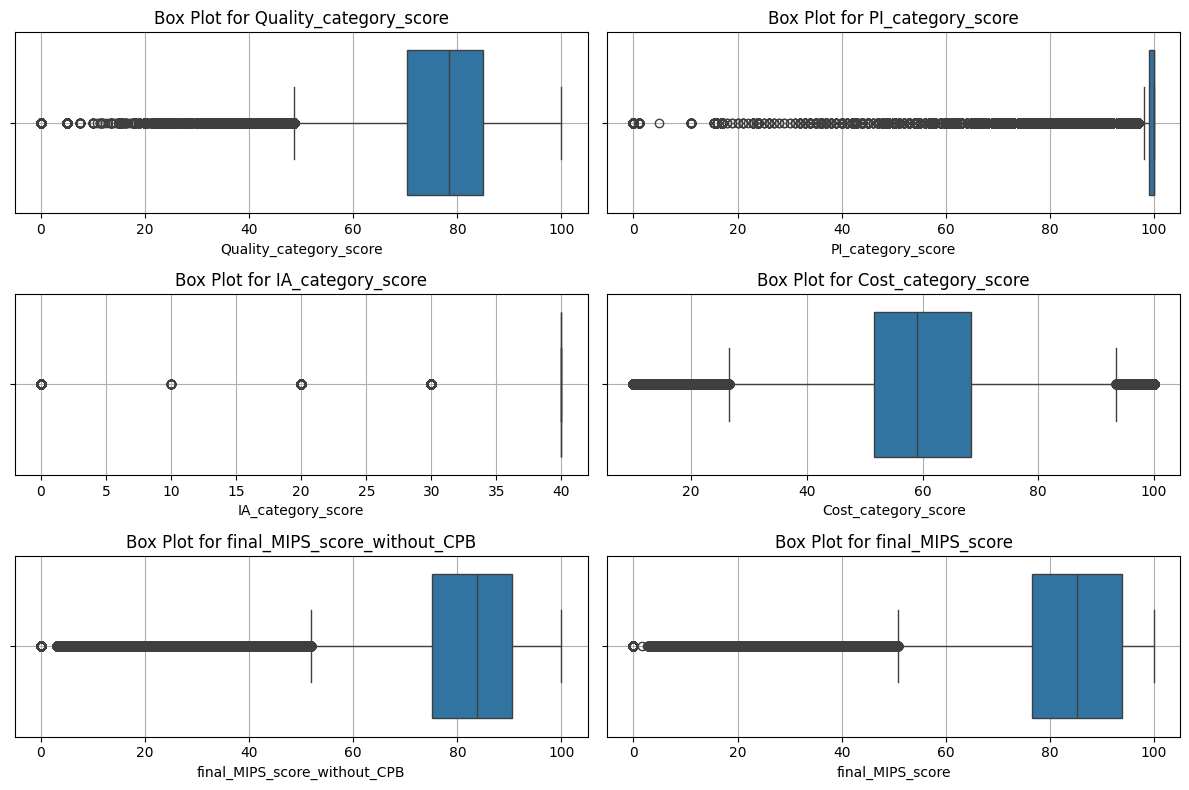

In [33]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw box plots for each numeric column
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)  # Create a subplot for each column
    sns.boxplot(x=pandas_df[col])
    plt.title(f'Box Plot for {col}')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Correlation Analysis

In [41]:
df.dtypes

[('NPI', 'int'),
 ('Org_PAC_ID', 'bigint'),
 ('Provider_Last_Name', 'string'),
 ('Provider_First_Name', 'string'),
 ('source', 'string'),
 ('Facility_based_scoring_Certification_number', 'string'),
 ('Facility_Name', 'string'),
 ('Quality_category_score', 'double'),
 ('PI_category_score', 'double'),
 ('IA_category_score', 'int'),
 ('Cost_category_score', 'double'),
 ('final_MIPS_score_without_CPB', 'double'),
 ('final_MIPS_score', 'double')]

In [42]:
numeric_columns = [col for col, type in df.dtypes if type in ["int", "float", "double"]]
numeric_columns

['NPI',
 'Quality_category_score',
 'PI_category_score',
 'IA_category_score',
 'Cost_category_score',
 'final_MIPS_score_without_CPB',
 'final_MIPS_score']

In [43]:
for col1 in numeric_columns:
    for col2 in ['final_MIPS_score_without_CPB']:
        print(f"Correlation between {col1} and {col2}:",
              df.stat.corr(col1, col2))


Correlation between NPI and final_MIPS_score_without_CPB: 0.0002560386774392421
Correlation between Quality_category_score and final_MIPS_score_without_CPB: 0.24505724936528664
Correlation between PI_category_score and final_MIPS_score_without_CPB: 0.19897977676870765
Correlation between IA_category_score and final_MIPS_score_without_CPB: 0.3210620867918019
Correlation between Cost_category_score and final_MIPS_score_without_CPB: -0.20081855963639056
Correlation between final_MIPS_score_without_CPB and final_MIPS_score_without_CPB: 1.0
Correlation between final_MIPS_score and final_MIPS_score_without_CPB: 0.6825031443959124


In [46]:
numeric_df = df.select(numeric_columns)

# Calculate correlation between all numeric columns
correlations = {}
for col in numeric_columns:
    correlations[col] = numeric_df.stat.corr(col, 'final_MIPS_score')

# Convert correlation results to Pandas DataFrame for visualization
corr_df = pd.DataFrame(list(correlations.items()), columns=['Column', 'Correlation_with_final_MIPS_score'])

# Display the correlation values
corr_df


,Column,Correlation_with_final_MIPS_score
0,NPI,-0.000213
1,Quality_category_score,0.451582
2,PI_category_score,0.387524
3,IA_category_score,0.559094
4,Cost_category_score,-0.178825
5,final_MIPS_score_without_CPB,0.682503
6,final_MIPS_score,1.000000


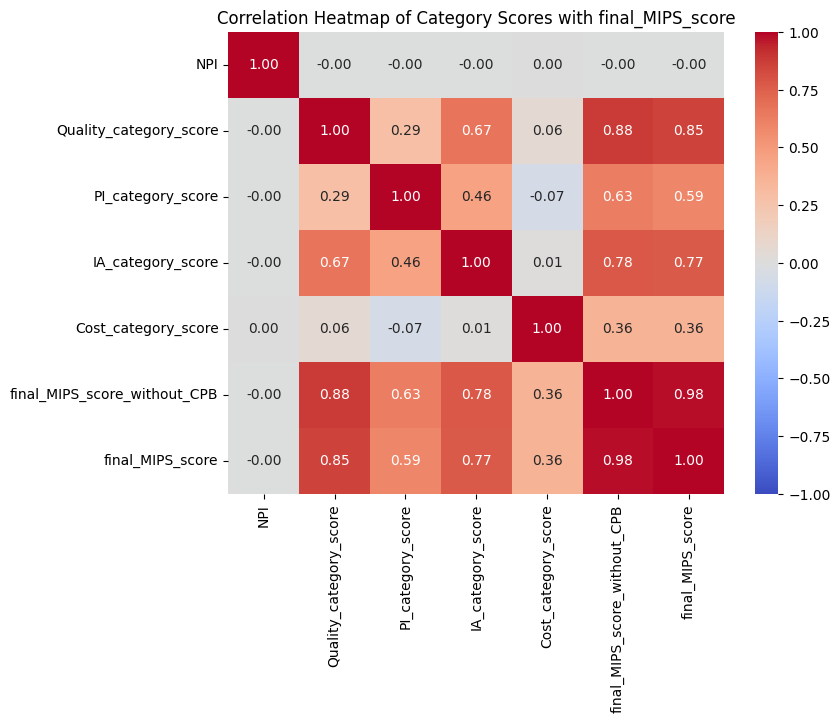

In [47]:
# Create a correlation matrix for heatmap
pandas_df = numeric_df.toPandas()
corr_matrix = pandas_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Category Scores with final_MIPS_score')
plt.show()

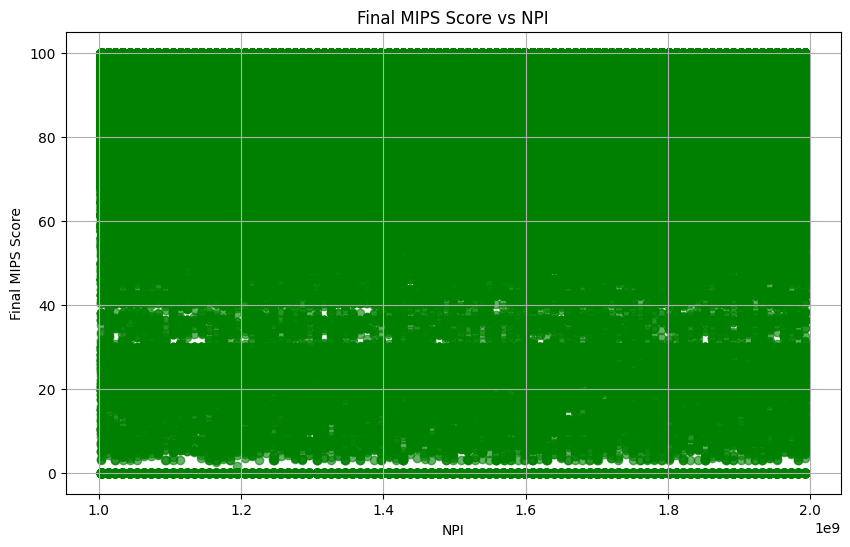

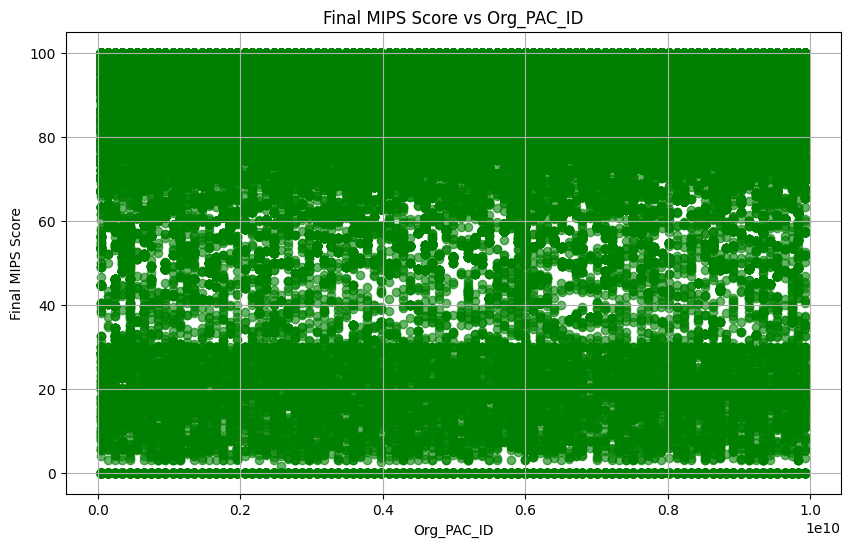

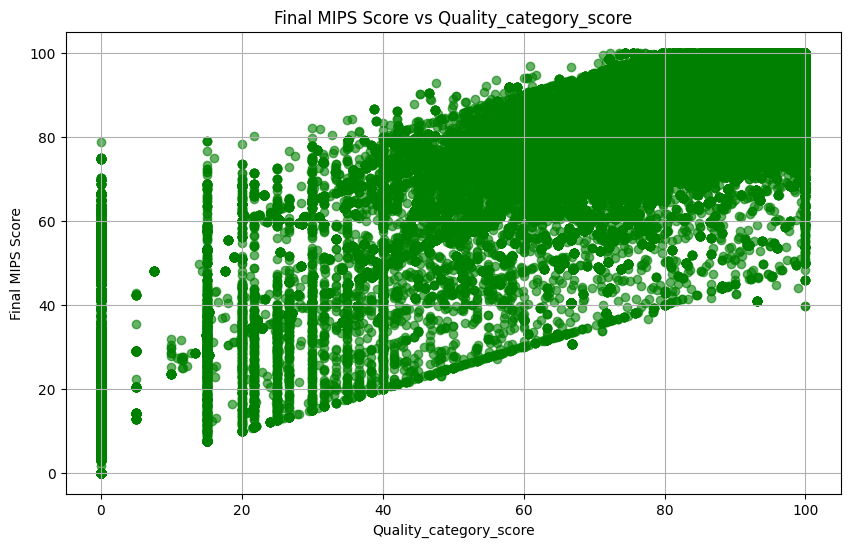

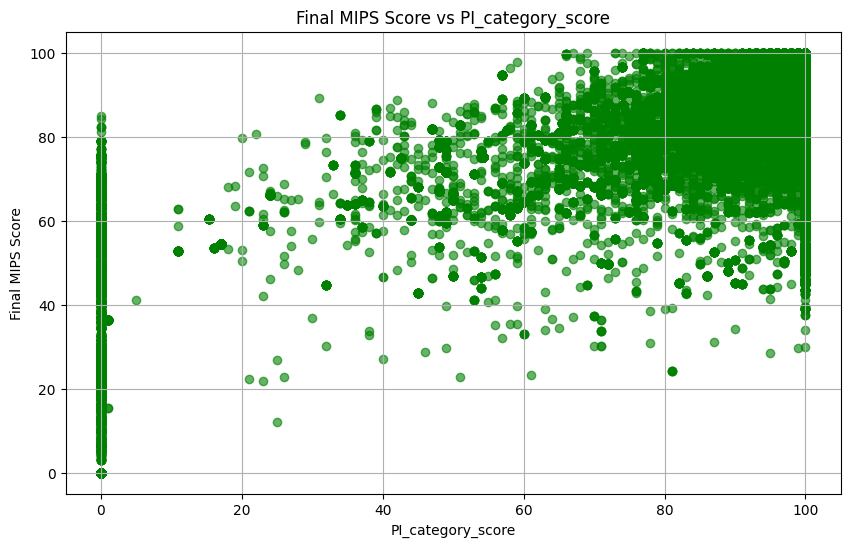

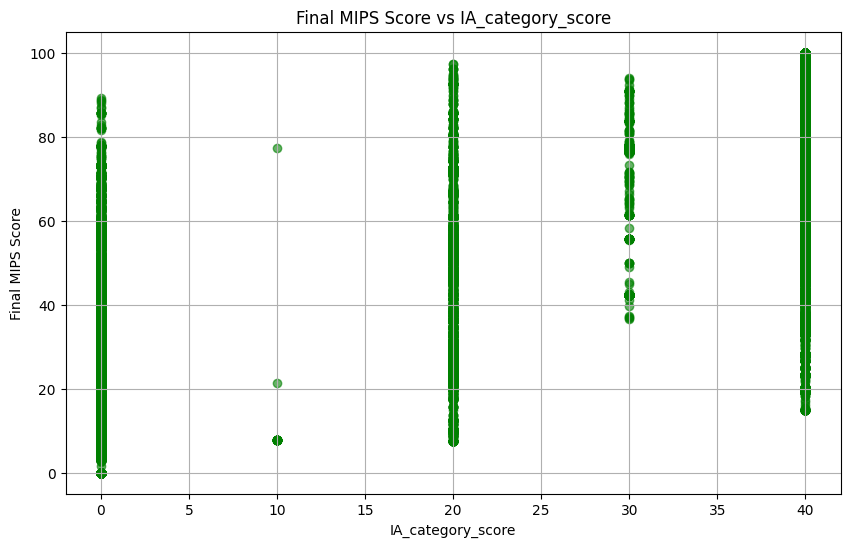

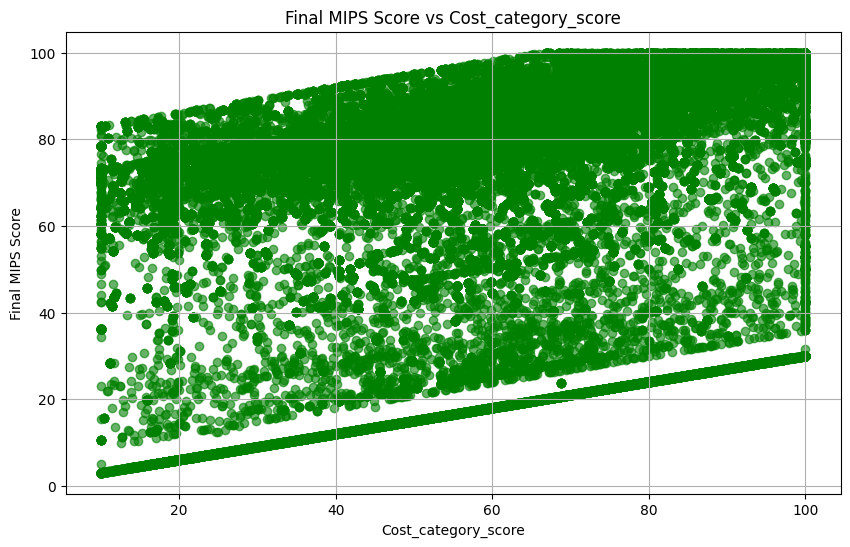

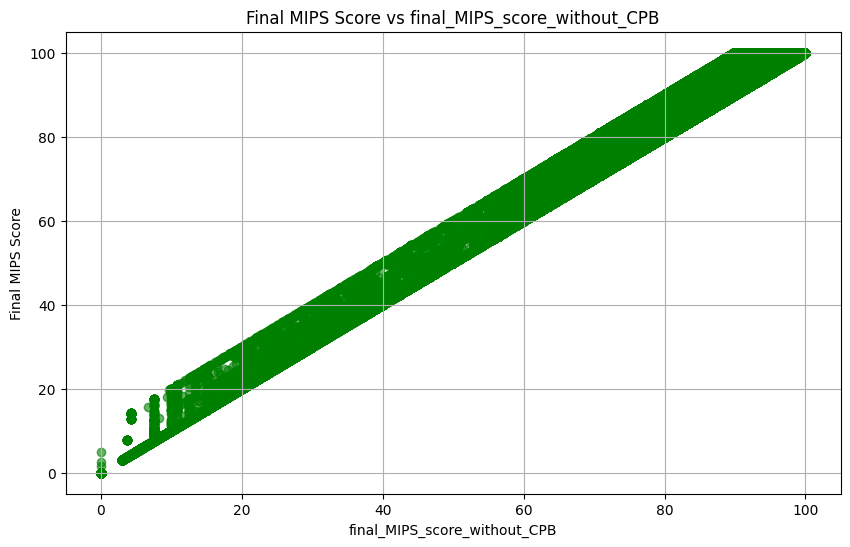

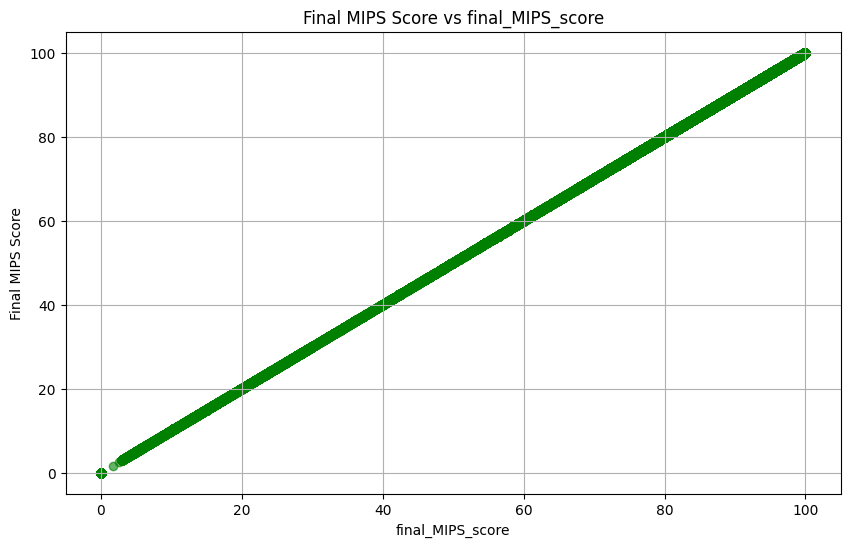

In [51]:
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(pandas_df[col], pandas_df['final_MIPS_score'], alpha=0.6, color='green')
    plt.title(f'Final MIPS Score vs {col}')
    plt.xlabel(col)
    plt.ylabel('Final MIPS Score')
    plt.grid(True)
    plt.show()